<a href="https://colab.research.google.com/github/ArturBudniak/MonteCarlo_TemperatureMeasurement/blob/main/Monte_Carlo_for_NTC_sensor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. User Manual

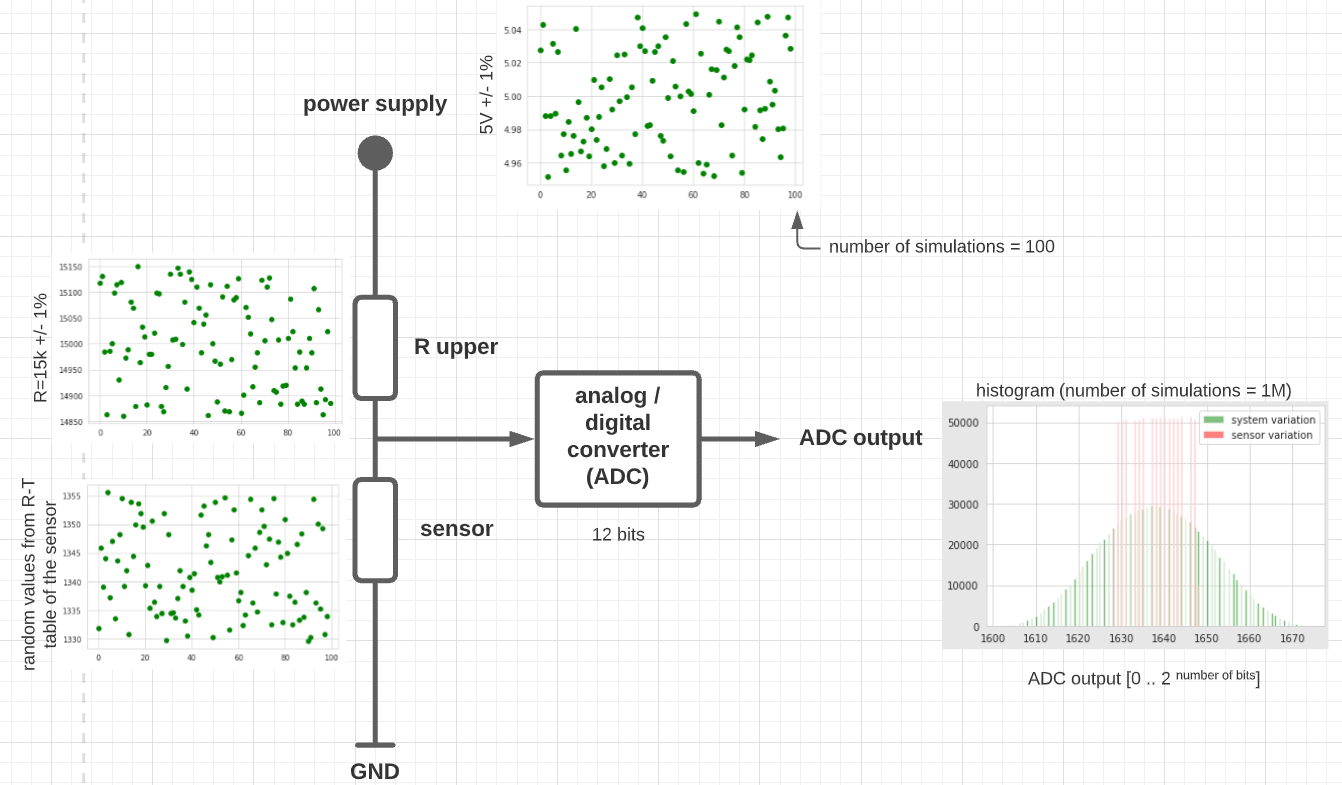

R-T table shall be stored in google spreadsheet file in the format presented below:

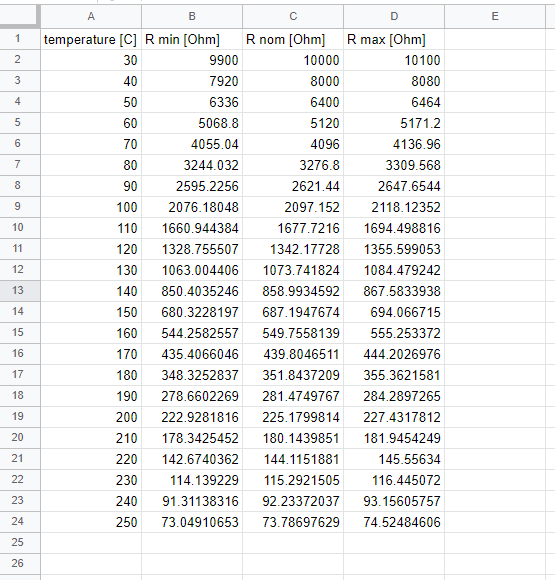

Bugs:
*  provide conversion table for whole ADC count range (0-4095 for 12bit)
*   conversion table should be sorted ascending (by counts), otherwise while loop in ADC_to_temperature function might not trigger
*   have correct column titles matching ones in the code

# 2. Setup (keep folded)

In [6]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


import numpy as np  # useful for many scientific computing in Python
import pandas as pd # primary data structure library
import seaborn as sns
import math
import random
import matplotlib.pyplot as plt

sns.set_style('whitegrid')

!pip install gspread
import gspread

!pip install gspread-dataframe
from gspread_dataframe import get_as_dataframe, set_with_dataframe

from matplotlib import pyplot

units = 1000000                                                                 #simulation size
count = units-1

def ADC_conversion(V_pin):                                                      # Voltage to ADC count conversion
  
  if ACU_variation == 1:
    conversion_array = np.array([math.floor((math.pow(2,bit_number) * V_pin_i)/V_supply_nom) for V_pin_i in V_pin])
    LSB_error_array = np.random.normal(0,LSB_error/3, count).round(0)
    conversion_array = conversion_array + LSB_error_array
  else:
    conversion_array = np.array([((math.pow(2,bit_number) * V_pin_i)/V_supply_nom) for V_pin_i in V_pin])
  return conversion_array.astype(int)

def ADC_to_temperature (ADC_counts):
#conversion table shall be in ascending order for ADC counts

  i=0

  if (ADC_counts < df_SW_conversion_table["ADC"].iloc[0]):
    print("lower limit of SW convertion table")
    return (df_SW_conversion_table["Temperature [C]"].iloc[0])
  elif (ADC_counts > df_SW_conversion_table["ADC"].iloc[len(df_SW_conversion_table)-1]):
    print("upper limit of SW convertion table")
    return (df_SW_conversion_table["Temperature [C]"].iloc[len(df_SW_conversion_table)-1])


  while (ADC_counts >= df_SW_conversion_table["ADC"].iloc[i]):                  #look for two closest ADC counts in the table
    lower_ADC = df_SW_conversion_table["ADC"].iloc[i]
    lower_temperature = df_SW_conversion_table["Temperature [C]"].iloc[i]
    higher_ADC = df_SW_conversion_table["ADC"].iloc[i+1]
    higher_temperature = df_SW_conversion_table["Temperature [C]"].iloc[i+1]
    #print(lower_ADC, higher_ADC)
    i = i + 1

  percentage_distance_from_lower = (ADC_counts-lower_ADC) / (higher_ADC - lower_ADC)
  temperature = (higher_temperature - lower_temperature)*percentage_distance_from_lower + lower_temperature

  return (temperature)

def self_heating_delta_NTC_is_upper():
  return ((V_supply_nom - V_adc_mean) * (V_supply_nom - V_adc_mean)/R_ntc_nomi) / (dissipation_factor/1000)
                                                                                # in calculateing temp increase die to self-heating, voltage and NTC variation might be neglected (<0.01)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#3. Authorize (keep folded)

In [8]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
from google.auth import default
creds, _ = default()

#4. Input data

In [17]:
#@title Sensor R-T table {display-mode: "form"}
link = "https://docs.google.com/spreadsheets/d/1uGNnNLcwYY450Orj9UaWIccLxrS6uskfTKQC6gg_6K8/edit?usp=sharing" #@param {type: "string"} 



#@title Sensor Cpk {display-mode: "form"}
Cpk_sensor =  1.67#@param 


#@title NTC dissipation factor [mW/°C] {display-mode: "form"}
dissipation_factor =  100000 #@param 

#@title Power supply voltage [V] {display-mode: "form"}
V_supply_nom =  5#@param
V_tol =  0#@param
Cpk_voltage =  0#@param

#@title Upper resistor [Ohm] {display-mode: "form"}

# R upper parameters
R_upper_nom =    1800#@param                                                   # set R_upper value: ADA = 6800, Hill = 15000
R_upper_tol = 0.001    #@param                                                   # set R_upper tolerance (for ADA and Hill it is 1%)

Cpk_R_upper =     1.67#@param

#@title Analog Digital Converter (ADC) {display-mode: "form"}
# Analog digital converter resolution
bit_number = 12      #@param                                                    # set ADC number of bits (ADA and Hill = 12 bit)
LSB_error =           7#@param                                                    # Least Significant Bits error

#@title Software Conversion Table (in ascending order for ADC counts) {display-mode: "form"}
link_SW_conversion_table = "https://docs.google.com/spreadsheets/d/15Ht1oDxCgsfHkQGqXZ2AbD150wsegyrrMskO_itXMrU/edit?usp=sharing" #@param {type: "string"} 



In [18]:
#@title Sensor Cpk {display-mode: "form"}
Cpk_sensor =  1.67#@param 


In [28]:
#@title NTC dissipation factor [mW/°C] {display-mode: "form"}
dissipation_factor =  1000 #@param 

In [20]:
#@title Power supply voltage [V] {display-mode: "form"}
V_supply_nom =  5#@param
V_tol =  0#@param
Cpk_voltage =  0#@param

In [21]:
#@title Upper resistor [Ohm] {display-mode: "form"}

# R upper parameters
R_upper_nom =    1800#@param                                                   # set R_upper value: ADA = 6800, Hill = 15000
R_upper_tol = 0.001    #@param                                                   # set R_upper tolerance (for ADA and Hill it is 1%)

Cpk_R_upper =     1.67#@param

In [22]:
#@title Analog Digital Converter (ADC) {display-mode: "form"}
# Analog digital converter resolution
bit_number = 12      #@param                                                    # set ADC number of bits (ADA and Hill = 12 bit)
LSB_error =           7#@param                                                    # Least Significant Bits error

### How NTC self-heating is being calculated

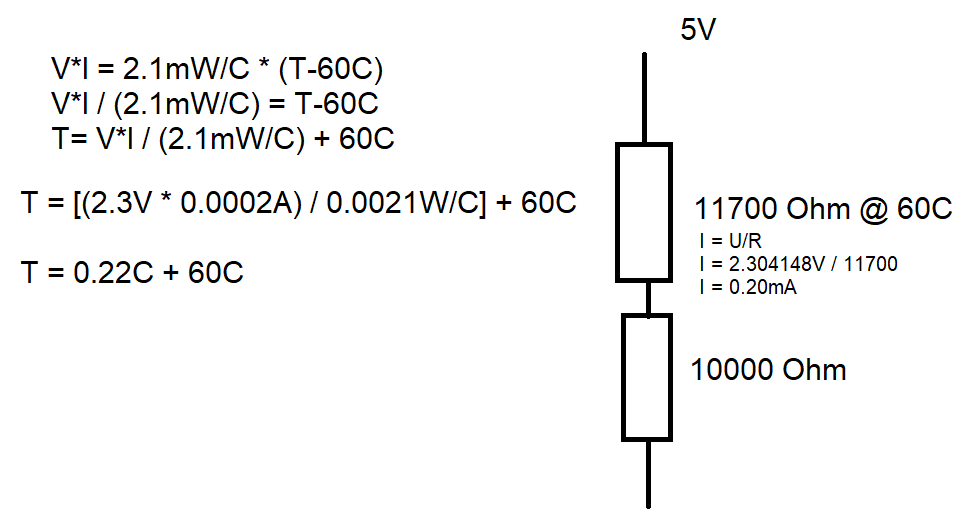

##4.1 Sensor R-T table loading (keep folded)

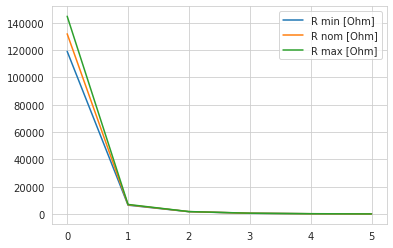

In [23]:
#gc = gspread.authorize(GoogleCredentials.get_application_default())
gc = gspread.authorize(creds)
sht = gc.open_by_url(link)

# Most common case: Sheet1
worksheet = sht.sheet1

df = get_as_dataframe(worksheet, parse_dates=True, usecols=[0,1,2,3], skiprows=0,evaluate_formulas=True, columns = ["temperature [C]",	"R min [Ohm]",	"R nom [Ohm]",	"R max [Ohm]"])
df.columns = ["temperature [C]",	"R min [Ohm]",	"R nom [Ohm]",	"R max [Ohm]"]
df.dropna(inplace=True)

df

df[["R min [Ohm]",	"R nom [Ohm]",	"R max [Ohm]"]].plot()

##4.2 SW Converstion Table loading (keep folded)

In [24]:
#gc = gspread.authorize(GoogleCredentials.get_application_default())
gc = gspread.authorize(creds)
sht = gc.open_by_url(link_SW_conversion_table)

# Most common case: Sheet1
worksheet = sht.sheet1

df_SW_conversion_table = get_as_dataframe(worksheet, parse_dates=True, usecols=[0,1], skiprows=1,evaluate_formulas=True, columns = ["ADC",	"Temperature [C]"])
df_SW_conversion_table.columns = ["ADC",	"Temperature [C]"]
df_SW_conversion_table.dropna(inplace=True)

df_SW_conversion_table #ADC counts shall be in ascending order (low to high)

,ADC,Temperature [C]
0,29.0,297.0
1,29.0,298.0
2,29.0,299.0
3,30.0,295.0
4,30.0,296.0
...,...,...
335,4070.0,-36.0
336,4071.0,-37.0
337,4073.0,-38.0
338,4074.0,-39.0


# 5. Calculations (unfold to see the results)

temperature from the R-T table  20.0  C
sensor self heating temperature delta  0.0 C
sensor error: + 1.5  C,  -1.5  C
system error: + 4.0  C,  -4.0  C


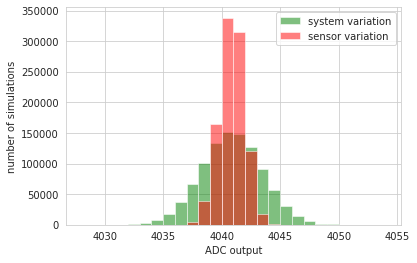

#######################################################################
temperature from the R-T table  100.0  C
sensor self heating temperature delta  0.0 C
sensor error: + 0.92  C,  -0.92  C
system error: + 0.94  C,  -0.94  C


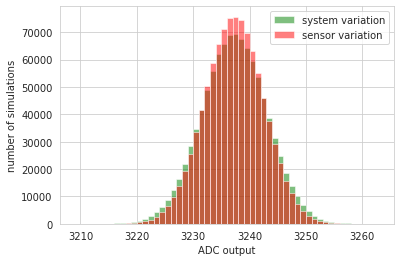

#######################################################################
temperature from the R-T table  150.0  C
sensor self heating temperature delta  0.0 C
sensor error: + 0.64  C,  -0.63  C
system error: + 0.67  C,  -0.66  C


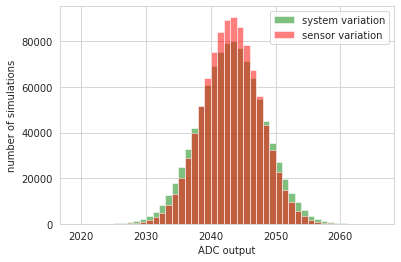

#######################################################################
temperature from the R-T table  200.0  C
sensor self heating temperature delta  0.02 C
sensor error: + 1.41  C,  -1.36  C
system error: + 1.6  C,  -1.55  C


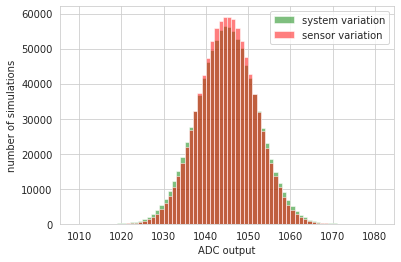

#######################################################################
temperature from the R-T table  250.0  C
sensor self heating temperature delta  0.07 C
sensor error: + 2.41  C,  -2.26  C
system error: + 2.69  C,  -2.54  C


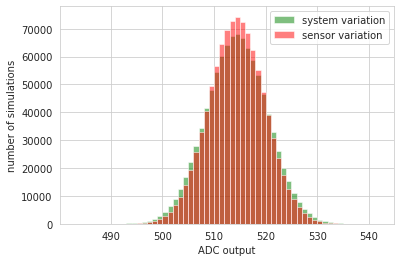

#######################################################################
temperature from the R-T table  300.0  C
sensor self heating temperature delta  0.17 C
sensor error: + 3.37  C,  -3.03  C
system error: + 3.84  C,  -3.49  C


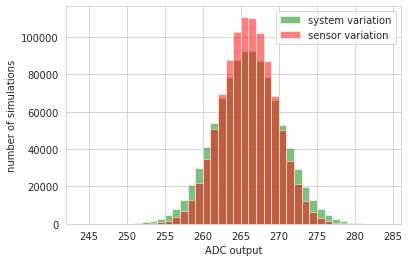

#######################################################################


In [31]:
for i in range(0, len(df)):                                                     #number of rows in R-T table
  V_adc_rv_counts = 0
  V_adc_range_counts =[]
  print("temperature from the R-T table ",df["temperature [C]"].iloc[i], " C")
  for ACU_variation in range (0,2):                                             # each time make two simulation: with and without ACU variation (only sensor / sensor+ACU) 
    prev_V_adc_range_counts = V_adc_range_counts                                # ACU = appliance control unit; contains resistor, voltage supply and ADC
    prev_V_adc_rv_counts = V_adc_rv_counts
    if ACU_variation == 1:
      R_upper_max = R_upper_nom * (1+R_upper_tol)
      R_upper_min = R_upper_nom * (1-R_upper_tol)
      V_supply_min=V_supply_nom*(1-V_tol)
      V_supply_max=V_supply_nom*(1+V_tol)                                                 
    else:
      R_upper_max = R_upper_nom
      R_upper_min = R_upper_nom
      V_supply_min=V_supply_nom
      V_supply_max=V_supply_nom

    
    temperature_K = df["temperature [C]"].iloc[i] + 273.15

    R_ntc_nomi = df["R nom [Ohm]"].iloc[i]                                      #create upper and lower spec limits for sensor resistance
    R_ntc_mini = df["R min [Ohm]"].iloc[i]
    R_ntc_maxi = df["R max [Ohm]"].iloc[i]

                                              
    
    if Cpk_R_upper != 0:                                                        #create random values between R_upper spec limits
      R_upper_rv = np.random.normal((R_upper_max - R_upper_min)/2 + R_upper_min, (R_upper_max - R_upper_min)/(6*Cpk_R_upper), count)
    else:
      R_upper_rv = np.random.rand(count)
      R_upper_rv = R_upper_rv * (R_upper_max - R_upper_min) + R_upper_min

    
    if Cpk_voltage !=0:                                                         #create random values for power supply voltage
      V_supply_rv = np.random.normal((V_supply_max - V_supply_min)/2 + V_supply_min, (V_supply_max - V_supply_min)/(6*Cpk_voltage), count)
    else:
      V_supply_rv = np.random.rand(count)                                         
      V_supply_rv = V_supply_rv * ((V_supply_max - V_supply_min)) + V_supply_min
    

    if Cpk_sensor != 0:                                                         #create random values for NTC between R_min and R_max taken from R-T table       
      R_ntc_rv = np.random.normal((R_ntc_maxi - R_ntc_mini)/2 + R_ntc_mini, (R_ntc_maxi - R_ntc_mini)/(6*Cpk_sensor), count)
    else:
      R_ntc_rv = np.random.rand(count)
      R_ntc_rv = R_ntc_rv * (R_ntc_maxi - R_ntc_mini) + R_ntc_mini


    #channel A--------------------------------------------------------------------

    V_adc_rv = V_supply_rv * (R_ntc_rv / (R_upper_rv + R_ntc_rv))                #voltage divider [+ -> R_upper -> sensor -> -]
    #V_adc_rv = V_supply_rv * (R_upper_rv / (R_upper_rv + R_ntc_rv))             #voltage divider [+ -> sensor -> R_lower -> -]

    V_adc_mean = np.average(V_adc_rv)
    V_adc_max = np.max(V_adc_rv)
    V_adc_min = np.min(V_adc_rv)

    #print("V_adc_mean", V_adc_mean)

    V_adc_rv_counts = ADC_conversion(V_adc_rv)                                  #change ACU input voltage into ADC counts
    V_adc_mean_counts = np.average(V_adc_rv_counts)
    #print("V_adc_mean_counts", V_adc_mean_counts)
    V_adc_max_counts = np.max(V_adc_rv_counts)
    V_adc_min_counts = np.min(V_adc_rv_counts)
    V_adc_range_counts = V_adc_max_counts - V_adc_min_counts
    #print("V_adc_range_counts", V_adc_range_counts)

    #print("read from conv table ",ADC_to_temperature(V_adc_mean_counts))
    temperature_range = abs(ADC_to_temperature(V_adc_max_counts) - ADC_to_temperature(V_adc_min_counts))

    self_heating_detla_temp = self_heating_delta_NTC_is_upper()                 # calculate self-heating effect (temperature rise)

    temperature_error_minus = -temperature_range/2 + self_heating_detla_temp
    temperature_error_plus =   temperature_range/2 + self_heating_detla_temp

    

    if ACU_variation == 0:
      print("sensor self heating temperature delta ",round(self_heating_detla_temp,2),"C")
      #print("sensor variation: ADC output range ",V_adc_range_counts," counts")
      print("sensor error: +",round(temperature_error_plus,2)," C, ",round(temperature_error_minus,2), " C")
      sensor_number_of_bins = V_adc_range_counts
    else:
      #print("system variation: ADC output range", V_adc_range_counts," counts")
      print("system error: +", round(temperature_error_plus,2)," C, ", round(temperature_error_minus,2), " C")
      system_number_of_bins = V_adc_range_counts


  #print("In temperature of ",df["temperature [C]"].iloc[i],"C the sensor variation is ", round(prev_V_adc_range_counts/V_adc_range_counts,3)) 
  #print("of the whole HW system variation measured on Analog-Digital-Converter ouput")


  
  
  pyplot.hist(V_adc_rv_counts, bins = system_number_of_bins, alpha=0.5, label='system variation', color = 'green')
  pyplot.hist(prev_V_adc_rv_counts, bins = sensor_number_of_bins, alpha=0.5, label='sensor variation', color = 'red')
  pyplot.legend(loc='upper right')
  pyplot.xlabel("ADC output")
  pyplot.ylabel("number of simulations")
  pyplot.show()

  # _ = plt.hist(V_supply_rv, bins=100)  # arguments are passed to np.histogram
  # plt.title("voltage")
  # plt.show()

  # _ = plt.hist(R_upper_rv, bins=100)  # arguments are passed to np.histogram
  # plt.title("R upper")
  # plt.show()

  # _ = plt.hist(R_ntc_rv, bins=100)  # arguments are passed to np.histogram
  # plt.title("sensor")
  plt.show()
  print("#######################################################################")

  

